In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import csv, json
import os
from scipy.signal import find_peaks
plt.style.use('bmh')


# Module

In [1]:
from Frog_extraction_module import *

In [162]:
def AnalyseExpConcTruncated(conc, peak_height=1500, expName = 'Noname', output_folder = ''):
    '''

    :param conc: Concentration of the CPC
    :param peak_height: expected peak height improving the peak finder algorithm
    :param expName: name of the experiment
    :param output_folder: folder to save the ouput (image and csv)
    :return: mean concentration before collection, after collection, mean between them (C_base),
     their difference (C_error), collection concentration, collection durationn
    '''
    conc = np.array(conc)
    if len(conc)<10:
        print("Error, len of exp to low...")
        return False
    conc_grad = np.gradient(conc)
    peaks1, _ = find_peaks(-conc_grad, height=peak_height)
    peaks2,_ = find_peaks(conc_grad, height=peak_height)
    if len(peaks1)>1:
        print("More than 1 peak found, taking the strongest one")
        peak1 = peaks1[np.argmin(conc_grad[peaks1])]
    else:
        peak1 = peaks1[0]

    if len(peaks2)>1:
        print("More than 1 peak found, taking the strongest one")
        peak2 = peaks2[np.argmax(conc_grad[peaks2])]
    else:
        peak2 = peaks2[0]

    S_begin = max(0, peak1-4*60)
    S_end = min(len(conc), peak2+4*60)

    X = np.arange(S_begin,S_end+1)

    C_before = conc[S_begin:peak1].mean()
    C_collection = conc[peak1:peak2+1].mean() # = conc_on in Nikunj's Code
    C_after = conc[peak2:S_end+1].mean()

    C_base = (C_after + C_before)/2 # = conc_ss in Nikunj's code
    C_error = abs(C_after-C_before)/2  # = for particle error

    Time_collection = peak2-peak1

    ylimit = [np.min([10000, 1.25*np.max(C_base)])]

    fig, ax = plt.subplots(layout='constrained', figsize=(5.5,3.5))
    ax.plot(X, conc[X], color='black', label='CPC Conc. Measure')
    #ax.plot(X, conc_grad[X], alpha=0.5, label='Conc. gradient')
    ax.hlines(C_base, xmin=S_begin, xmax=X[-1], linestyles='-', alpha = 0.7, colors='#8B5C95', label = 'Conc. w/o col.')
    ax.hlines(C_collection, xmin=S_begin, xmax=X[-1], linestyles='-', alpha=0.8, colors='#7A9BFF', label = 'Conc. during col.')
    ax.hlines([C_before, C_after],xmin=S_begin, xmax=X[-1], linestyles='--', color='#C6A8D2', label = 'Conc. error')
    ax.vlines([peak1], ymin=0, ymax=ylimit, linestyles='-', alpha=0.8, color='green', label= 'Col. start')
    ax.vlines([peak2], ymin=0, ymax=ylimit, linestyles='-', alpha=0.8, color='red', label= 'Col. stop')
    #ax.fill_between(np.arange(peak1,peak2), C_before, C_after, alpha=0.4, color = '#D2A8C7', label='Conc. error')
    ax.set_ylabel(r'Concentration [$p \cdot cm^{-3}$]')
    ax.set_xlabel('Elapsed time [s]')
    fig.legend(bbox_to_anchor=(1, -0.2), loc='lower right', ncol = 3)
    #fig.legend( bbox_to_anchor=(1.15, 0.6), loc='center')
    fig.savefig(output_folder + f"{expName}ConcentrationImage.jpg", dpi=300 , bbox_inches='tight')
    plt.show()

    return C_before, C_after, C_base, C_error, C_collection, Time_collection

# Initialization

In [153]:
specific_data_folder = "Data/Glucose"
frog_data_folder = os.path.join(specific_data_folder,"FridasFrogData")
filename = os.path.join(frog_data_folder,"20230515glucose.txt")

In [157]:
FidasEx = FidasFrogData(filename)

In [158]:
sample = FidasEx.extract_sample(start_str="19min", stop_str="48min")

['timestamp',
 'PM 1 [µg/m³]',
 'PM 2.5 [µg/m³]',
 'PM 4 [µg/m³]',
 'PM 10 [µg/m³]',
 'PM tot. [µg/m³]',
 'dCn [1/cm³]',
 'Latitude',
 'Longitude',
 'timestamp.1',
 'temperature [°C]',
 'rel. humidity [%]',
 'ambient pressure [hPa]']

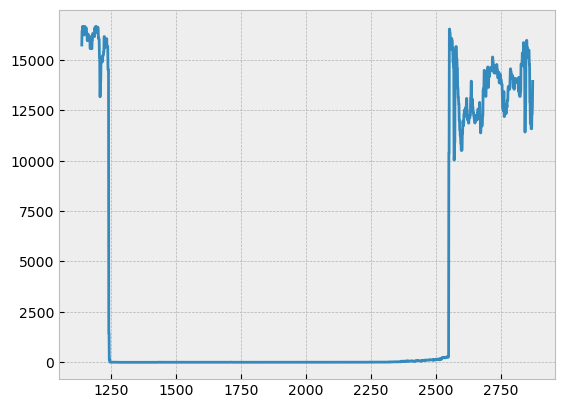

In [168]:
plt.plot(sample["dCn"])
FidasEx.units

In [165]:
conc = sample["PM1"].to_numpy()
conc[0]

1573.06

More than 1 peak found, taking the strongest one
More than 1 peak found, taking the strongest one


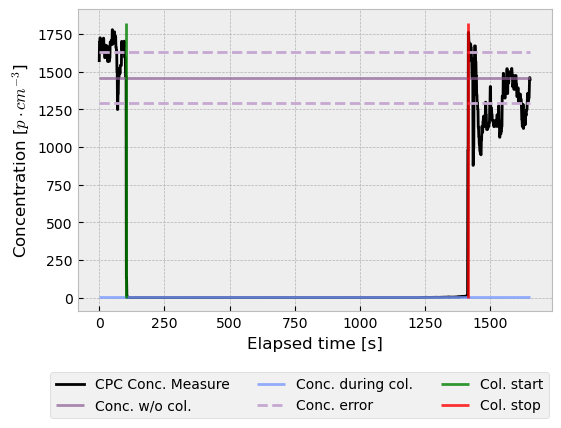

(1627.6594174757277,
 1290.655601659751,
 1459.1575095677395,
 168.5019079079883,
 1.8396338672768877,
 1310)

In [166]:
AnalyseExpConcTruncated(conc, peak_height=100)